In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# NLP essentials
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/flix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/flix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/flix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/flix/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Load Data
try:
    df = pd.read_csv('customer_support_tickets.csv')
    print("Data loaded successfully.")
    print(f"Shape: {df.shape}")
    print(df.columns.tolist())
except FileNotFoundError:
    print("Error: File 'customer_support_tickets.csv' not found. Please ensure it is in the same directory.")

Data loaded successfully.
Shape: (8469, 17)
['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating']


In [4]:
# Basic Info
df.info()
df.head()

<class 'pandas.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   str    
 2   Customer Email                8469 non-null   str    
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   str    
 5   Product Purchased             8469 non-null   str    
 6   Date of Purchase              8469 non-null   str    
 7   Ticket Type                   8469 non-null   str    
 8   Ticket Subject                8469 non-null   str    
 9   Ticket Description            8469 non-null   str    
 10  Ticket Status                 8469 non-null   str    
 11  Resolution                    2769 non-null   str    
 12  Ticket Priority               8469 non-null   str    
 13  Ticket Channel

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [5]:
# Data Preprocessing
# 1. Create a combined text column
df['text'] = df['Ticket Subject'].fillna('') + " " + df['Ticket Description'].fillna('')

# 2. Drop rows with missing target values
df.dropna(subset=['Ticket Type', 'Ticket Priority'], inplace=True)

print(f"New shape after dropping missing targets: {df.shape}")

New shape after dropping missing targets: (8469, 18)


In [6]:
# Text Cleaning Function
stop_words = set(stopwords.words('english')).union({'val', 'pm', 'en', 'hello', 'hi', 'thanks', 'please', 'regards'})
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Remove non-alphabetic characters and lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    cleaned = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(cleaned)

print("Cleaning texts... this may take a moment.")
df['cleaned_text'] = df['text'].apply(clean_text)
df[['text', 'cleaned_text']].head()

Cleaning texts... this may take a moment.


,text,cleaned_text
0,Product setup I'm having an issue with the {pr...,product setup im issue productpurchased assist...
1,Peripheral compatibility I'm having an issue w...,peripheral compatibility im issue productpurch...
2,Network problem I'm facing a problem with my {...,network problem im facing problem productpurch...
3,Account access I'm having an issue with the {p...,account access im issue productpurchased assis...
4,Data loss I'm having an issue with the {produc...,data loss im issue productpurchased assist not...


In [7]:
# Split Data
X = df['cleaned_text']
y_category = df['Ticket Type']
y_priority = df['Ticket Priority']

# Using the same random state ensures X_train is the same for both tasks
X_train, X_test, y_cat_train, y_cat_test = train_test_split(X, y_category, test_size=0.2, random_state=42)
_, _, y_prio_train, y_prio_test = train_test_split(X, y_priority, test_size=0.2, random_state=42)

In [8]:
# --- 1. Category Classification Model ---
print("Training Category Model...")
cat_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=5000)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

cat_pipeline.fit(X_train, y_cat_train)
print("Category Model Trained.")

Training Category Model...
Category Model Trained.


In [9]:
# Evaluate Category Model
cat_predictions = cat_pipeline.predict(X_test)
print("\n--- Category Classification Report ---")
print(classification_report(y_cat_test, cat_predictions))


--- Category Classification Report ---
                      precision    recall  f1-score   support

     Billing inquiry       0.18      0.18      0.18       357
Cancellation request       0.17      0.18      0.18       327
     Product inquiry       0.17      0.20      0.18       316
      Refund request       0.18      0.17      0.18       345
     Technical issue       0.22      0.19      0.20       349

            accuracy                           0.18      1694
           macro avg       0.18      0.18      0.18      1694
        weighted avg       0.19      0.18      0.18      1694



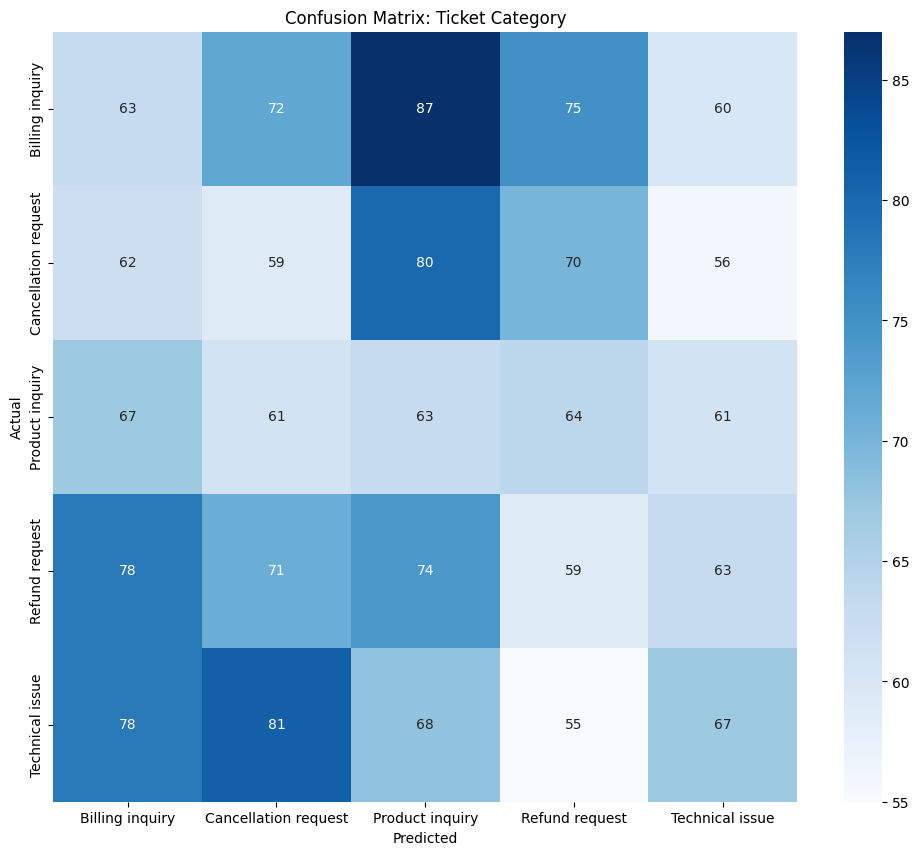

In [10]:
# Visualize Category Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_cat_test, cat_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cat_pipeline.classes_, 
            yticklabels=cat_pipeline.classes_)
plt.title('Confusion Matrix: Ticket Category')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
# --- 2. Priority Classification Model ---
print("Training Priority Model...")
# Using Random Forest for priority as it handles non-linear relationships well
prio_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

prio_pipeline.fit(X_train, y_prio_train)
print("Priority Model Trained.")

Training Priority Model...
Priority Model Trained.


In [12]:
# Evaluate Priority Model
prio_predictions = prio_pipeline.predict(X_test)
print("\n--- Priority Classification Report ---")
print(classification_report(y_prio_test, prio_predictions))


--- Priority Classification Report ---
              precision    recall  f1-score   support

    Critical       0.24      0.27      0.26       411
        High       0.27      0.27      0.27       409
         Low       0.26      0.22      0.24       415
      Medium       0.28      0.29      0.28       459

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



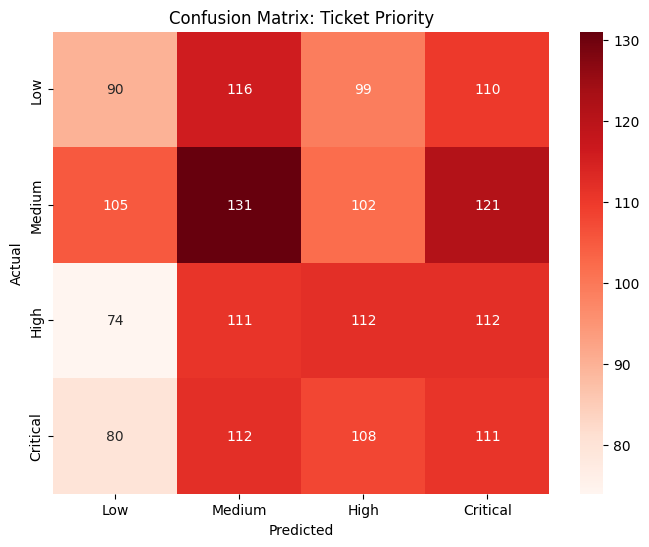

In [13]:
# Visualize Priority Confusion Matrix
plt.figure(figsize=(8, 6))
cm_p = confusion_matrix(y_prio_test, prio_predictions, labels=['Low', 'Medium', 'High', 'Critical'])
sns.heatmap(cm_p, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Low', 'Medium', 'High', 'Critical'],
            yticklabels=['Low', 'Medium', 'High', 'Critical'])
plt.title('Confusion Matrix: Ticket Priority')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
# --- Prediction Function ---
def predict_ticket_info(text):
    cleaned = clean_text(text)
    
    # Predict
    cat_pred = cat_pipeline.predict([cleaned])[0]
    prio_pred = prio_pipeline.predict([cleaned])[0]
    
    # Confidence scores
    cat_prob = np.max(cat_pipeline.predict_proba([cleaned])) * 100
    prio_prob = np.max(prio_pipeline.predict_proba([cleaned])) * 100
    
    print(f"Original Text: {text}")
    print(f"\n--- Prediction ---")
    print(f"Category: {cat_pred} (Confidence: {cat_prob:.2f}%)")
    print(f"Priority: {prio_pred} (Confidence: {prio_prob:.2f}%)")
    print("="*30 + "\n")

# Test on new examples
example_1 = "I cannot login to my account, password reset link is broken"
example_2 = "The billing amount on my invoice is incorrect, please refund me"
example_3 = "System is completely down, getting 500 errors on API"

predict_ticket_info(example_1)
predict_ticket_info(example_2)
predict_ticket_info(example_3)

Original Text: I cannot login to my account, password reset link is broken

--- Prediction ---
Category: Technical issue (Confidence: 24.43%)
Priority: High (Confidence: 48.00%)

Original Text: The billing amount on my invoice is incorrect, please refund me

--- Prediction ---
Category: Technical issue (Confidence: 32.10%)
Priority: High (Confidence: 34.00%)

Original Text: System is completely down, getting 500 errors on API

--- Prediction ---
Category: Technical issue (Confidence: 26.89%)
Priority: Critical (Confidence: 38.00%)



In [15]:
# Save Models
import os
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(cat_pipeline, 'models/category_model.pkl')
joblib.dump(prio_pipeline, 'models/priority_model.pkl')
print("Models saved to 'models/' directory.")

Models saved to 'models/' directory.
